In [1]:
import numpy as np
import pandas as pd
from Gen_data import SimulationStudy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from econml.metalearners import TLearner
from sklearn.model_selection import train_test_split
from econml.dml import CausalForestDML
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from econml.grf import CausalForest, RegressionForest
import shap
from __future__ import annotations

Define Necessary Functions

In [2]:
#Split into train and test set
def get_split(simulation: pd.DataFrame) -> tuple[pd.DataFrame]:
    
    train_df, test_df = train_test_split(simulation, test_size=0.5, random_state=42)

    # Extract features and target variables for training
    X_train = train_df[[col for col in simulation.columns if col.startswith('X')]]
    T_train = train_df['T']
    Y_train = train_df['y']

    # Extract features and true CATE for testing
    X_test = test_df[[col for col in simulation.columns if col.startswith('X')]]
    T_test = test_df['T']
    y_test = test_df['y']

    true_cate_test = test_df[['CATE', 'T']]

    return train_df, test_df, X_train, Y_train, T_train, X_test, T_test, y_test, true_cate_test

In [3]:
#Create OLS feature-treatment interactions
def get_ols_features(X_train: pd.DataFrame, T_train: pd.DataFrame, X_test: pd.DataFrame, T_test: pd.DataFrame) -> tuple[pd.DataFrame]:  

    interactions_train = pd.DataFrame()
    interactions_test = pd.DataFrame()


    for col in X_train.columns:
        interactions_train[f'{col}_T'] = X_train[col]*T_train
        interactions_test[f'{col}_T'] = X_test[col]*T_test


    X_train_ols = X_train.join(interactions_train)
    X_test_ols = X_test.join([interactions_test, pd.DataFrame(T_test, columns=['T'])])
    #X_test_ols.join(T)
    return X_train_ols, X_test_ols



In [4]:
def plot_predict_cate_corr(est_cate: np.array|pd.DataFrame, true_cate_test: np.array|pd.DataFrame):
    
    plt.figure(figsize=(8, 8))
    plt.scatter(est_cate, true_cate_test, alpha=0.5)    
    plt.plot([min(true_cate_test), max(true_cate_test)], [min(true_cate_test), max(true_cate_test)], '--', color='red')
    plt.xlabel('Estimated CATE')
    plt.ylabel('True CATE')
    plt.grid(True)
    plt.show()

    if type(est_cate) == pd.DataFrame:
        reg = LinearRegression().fit(est_cate, true_cate_test)
    else:
        est_cate = est_cate.reshape(-1,1)
        reg = LinearRegression().fit(est_cate, true_cate_test)

    print(f'Correlation between true and predicted CATE: {reg.score(est_cate, true_cate_test)}')

In [5]:
def coverage(ci_bounds):
    column_names = ['Lower Bound', 'Upper Bound', 'True CATE']
    ci_bounds = pd.DataFrame(ci_bounds, columns = column_names)
    ci_bounds['coverage'] = np.where((ci_bounds['Lower Bound'] <= ci_bounds['True CATE']) & (ci_bounds['True CATE'] <= ci_bounds['Upper Bound']), 1, 0)
    coverage = np.sum(ci_bounds['coverage'])/ci_bounds['coverage'].count()

    return coverage

Create Simulations

In [6]:
#Create simulations

sim_dict = {}

for p in [20, 30, 40, 50]:
    for n in [500, 1000, 2000, 4000]:
        sim: SimulationStudy = SimulationStudy(p=p, mean_correlation=0.1, cor_variance=0.2, n=n, no_feat_cate=3, non_linear='quadratic')
        simulation = sim.create_dataset()


        key = f'Simulation_{p}_{n}'
        value = simulation

        sim_dict[key]= value


In [ ]:
#cov, mean = sim.get_covariance_matrix()
#cov = pd.DataFrame(cov)
#np.mean(cov.to_numpy())

In [7]:
#Split df into train and test data

splits_dict = {}

for key, value in sim_dict.items():

    train_df, test_df, X_train, Y_train, T_train, X_test, T_test, y_test, true_cate_test = get_split(value)
    
    temp_dict = {'train_df': train_df, 'test_df': test_df, 
                   'X_train': X_train, 'Y_train': Y_train, 
                   'T_train': T_train, 'X_test': X_test, 
                   'T_test': T_test, 'Y_test': y_test, 
                   'true_cate_test': true_cate_test}

        
    splits_dict[key] = temp_dict



OLS Model

In [8]:
#Estimate a fully feature-treatment interacted model

x_train_ols, x_test_ols = get_ols_features(splits_dict['Simulation_20_2000']['X_train'], splits_dict['Simulation_20_2000']['T_train'],
                                            splits_dict['Simulation_20_2000']['X_test'], splits_dict['Simulation_20_2000']['T_test'])

In [9]:
def ols_estimator(x_train_ols: pd.DataFrame, y_train: pd.DataFrame, x_test_ols: pd.DataFrame, true_cate_test: pd.DataFrame) -> tuple[pd.DataFrame, int]:

    #Create OLS object
    ols = LinearRegression()

    #Fit OLS 
    ols.fit(x_train_ols, y_train)

    #Estimate CATE
    x_test_ols = x_test_ols[x_test_ols['T']==1]
    x_test_ols = x_test_ols[[col for col in x_test_ols.columns if col.startswith('X') and col.endswith('T')]]
    
    coeff = pd.DataFrame(ols.coef_, x_train_ols.columns).T
    coeff = coeff[[col for col in coeff.columns if col.startswith('X') and col.endswith('T')]].T
    
    estimated_cate = x_test_ols.dot(coeff)
        
    #Calculate MSE
    true_cate_test = true_cate_test[true_cate_test['T'] == 1]
    true_cate_test = true_cate_test['CATE']

    OLS_MSE = mean_squared_error(true_cate_test, estimated_cate)

    return coeff, estimated_cate, OLS_MSE 
    

In [11]:
coeff, estimated_cate_ols, ols_MSE = ols_estimator(x_train_ols, splits_dict['Simulation_20_2000']['Y_train'], x_test_ols, splits_dict['Simulation_20_2000']['true_cate_test'])

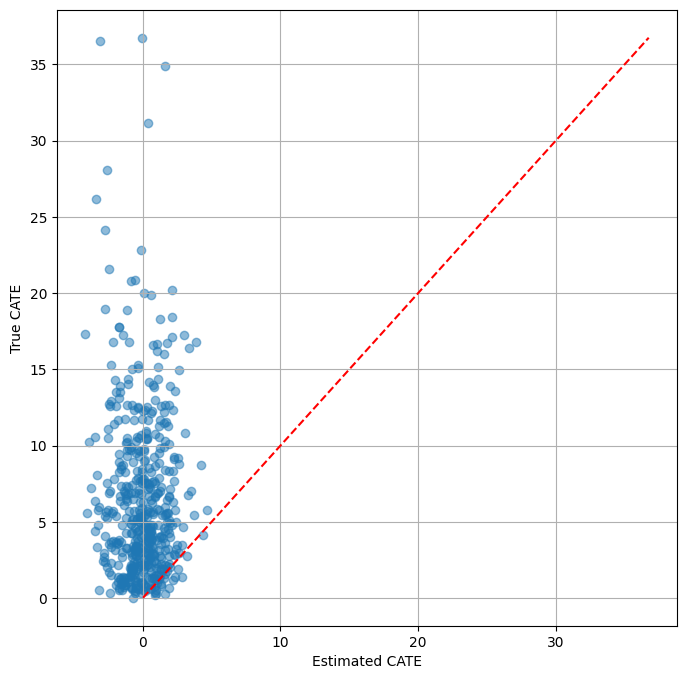

Correlation between true and predicted CATE: 0.0016207533758610948


In [12]:
true_cate_test = splits_dict['Simulation_20_2000']['true_cate_test']
true_cate_test = true_cate_test[true_cate_test['T'] == 1]
true_cate_test = true_cate_test['CATE']
plot_predict_cate_corr(estimated_cate_ols, true_cate_test)

T-Learner

In [8]:
def TLearner_estimator(Y_train: pd.DataFrame, T_train: pd.DataFrame, X_train: pd.DataFrame, X_test: pd.DataFrame, true_cate_test: pd.DataFrame) -> tuple[np.ndarray, float]:

    Y_train = Y_train.to_numpy()
    T_train = T_train.to_numpy()
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    true_cate_test = true_cate_test['CATE'].to_numpy()
    
    est_t = TLearner(models=RandomForestRegressor(n_estimators=1000))
    est_t.fit(Y=Y_train, T=T_train, X=X_train)
    estimated_cate_t = est_t.effect(X_test)
    T_MSE = mean_squared_error(true_cate_test, estimated_cate_t)
   

    return estimated_cate_t, T_MSE

estimated_cate_t, t_MSE = TLearner_estimator(splits_dict['Simulation_20_2000']['Y_train'], splits_dict['Simulation_20_2000']['T_train'], 
                                             splits_dict['Simulation_20_2000']['X_train'], splits_dict['Simulation_20_2000']['X_test'],
                                             splits_dict['Simulation_20_2000']['true_cate_test'])



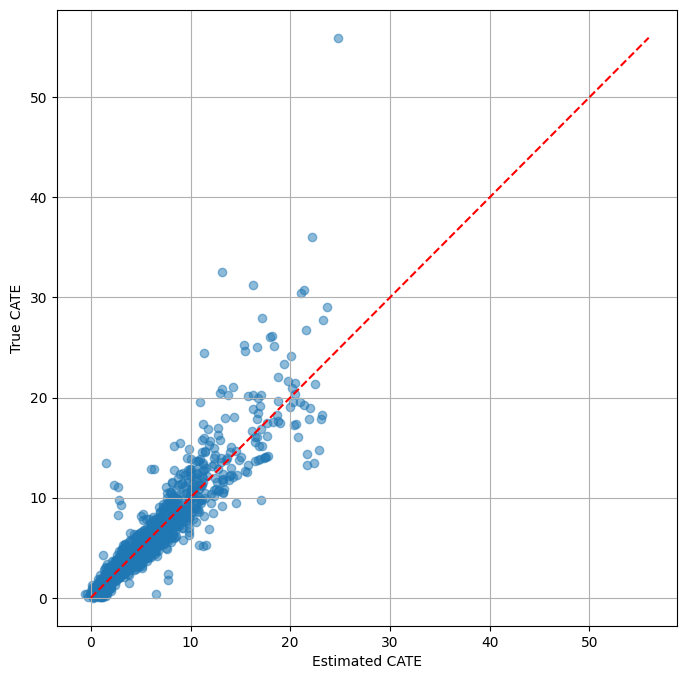

Correlation between true and predicted CATE: 0.8166417529904292


In [9]:
plot_predict_cate_corr(estimated_cate_t, splits_dict['Simulation_20_2000']['true_cate_test']['CATE'])

Causal Forest DML

In [10]:
def CF_DML(Y_train: pd.DataFrame, T_train: pd.DataFrame, X_train: pd.DataFrame, X_test: pd.DataFrame, true_cate_test: pd.DataFrame) -> tuple[np.ndarray, float]:
 
    Y_train = Y_train.to_numpy()
    T_train = T_train.to_numpy()
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    true_cate_test = true_cate_test['CATE'].to_numpy()

#Estimate the causal forest model
    est_cfdml = CausalForestDML(model_y='auto',
                        model_t=DummyClassifier(),
                        discrete_treatment=True,
                        n_estimators=1000,
                        cv=5,
                        random_state=42,
                        criterion='mse',
                        honest=True)

    est_cfdml.fit(Y=Y_train, T=T_train, X=X_train, W=None, cache_values=True)
    estimated_cate = est_cfdml.effect(X_test)

    cfdml_lb, cfdml_ub = est_cfdml.effect_interval(X_test)
    ci_bounds = np.column_stack((cfdml_lb, cfdml_ub, true_cate_test))


    mse = mean_squared_error(true_cate_test, estimated_cate)

    return estimated_cate, mse, ci_bounds

estimated_cate_dml, cf_dml_MSE, ci_bounds_cfdml = CF_DML(splits_dict['Simulation_50_4000']['Y_train'], splits_dict['Simulation_50_4000']['T_train'], 
                                       splits_dict['Simulation_50_4000']['X_train'], splits_dict['Simulation_50_4000']['X_test'],
                                       splits_dict['Simulation_50_4000']['true_cate_test'])



In [16]:
print(cf_dml_MSE)

17.204998649844406


In [11]:
coverage(ci_bounds_cfdml)

0.448

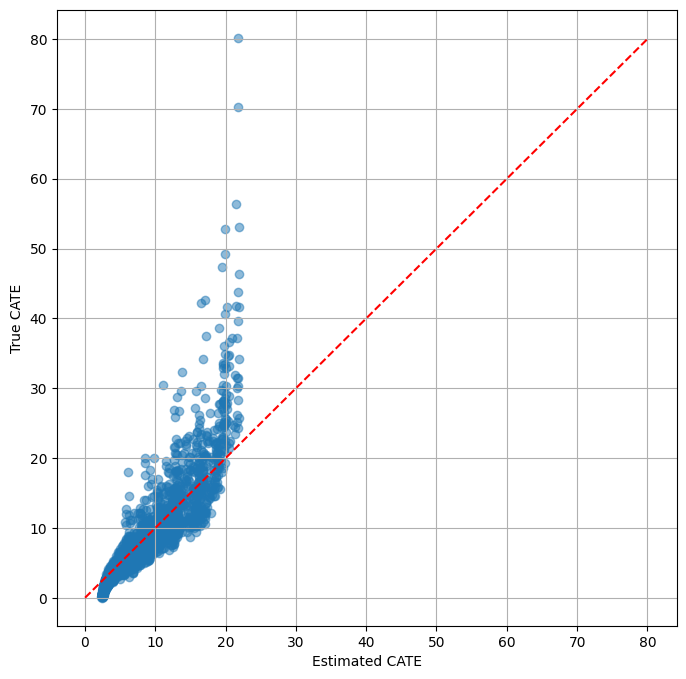

Correlation between true and predicted CATE: 0.7646785254294546


In [12]:
plot_predict_cate_corr(estimated_cate_dml, splits_dict['Simulation_50_4000']['true_cate_test']['CATE'])

In [13]:
est_rf = RegressionForest(n_estimators=1000)
est_rf.fit(y=splits_dict['Simulation_30_4000']['Y_train'], X=splits_dict['Simulation_30_4000']['X_train'])
estimated_cate = est_rf.predict(splits_dict['Simulation_30_4000']['X_test'])
est_rf.feature_importances_


array([0.01359575, 0.10765511, 0.82782276, 0.00105633, 0.00129711,
       0.00239837, 0.00105277, 0.00090576, 0.00114959, 0.00114999,
       0.00121619, 0.00138299, 0.00313541, 0.00166777, 0.00162815,
       0.00145188, 0.00126454, 0.00145642, 0.00111977, 0.00116911,
       0.00529722, 0.00210935, 0.00098125, 0.0077249 , 0.00129047,
       0.00207224, 0.00117525, 0.00136718, 0.00236329, 0.00204305])

In [15]:
mse = mean_squared_error(splits_dict['Simulation_30_4000']['true_cate_test']['CATE'], estimated_cate)
print(mse)

24.497055016754377


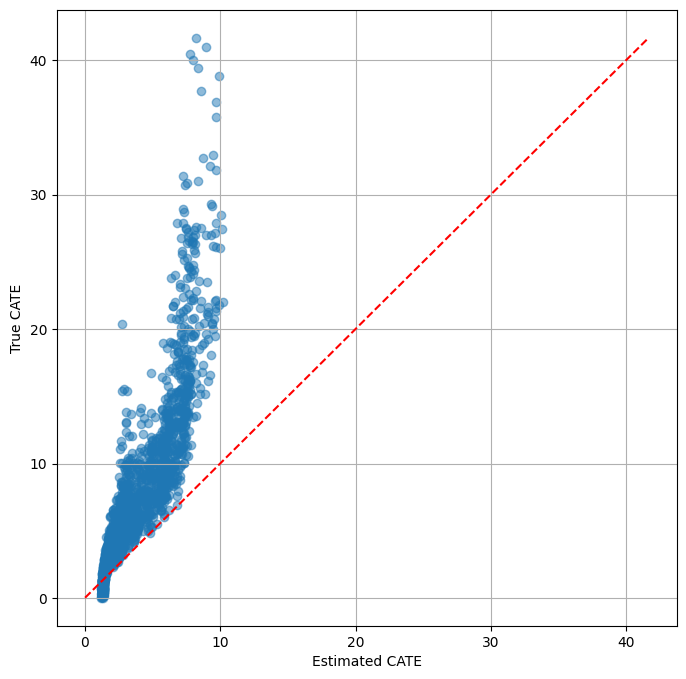

Correlation between true and predicted CATE: 0.7881516562449029


In [16]:
plot_predict_cate_corr(estimated_cate, splits_dict['Simulation_30_4000']['true_cate_test']['CATE'])

In [ ]:
splits_dict['Simulation_20_2000']['true_cate_test']['CATE']

In [17]:
def GRF_estimator(Y_train: pd.DataFrame, T_train: pd.DataFrame, X_train: pd.DataFrame, X_test: pd.DataFrame, true_cate_test: pd.DataFrame) -> tuple[np.ndarray, float]:

    Y_train = Y_train.to_numpy()
    T_train = T_train.to_numpy()
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    true_cate_test = true_cate_test['CATE'].to_numpy()


    est_grf = CausalForest(random_state=42, n_estimators=1000)
    
    est_grf.fit(y=Y_train, T=T_train, X=X_train)

    estimated_cate = est_grf.predict(X_test)
    lb, ub = est_grf.predict_interval(X_test)
    ci_bounds = np.column_stack((lb, ub, true_cate_test))


    mse = mean_squared_error(true_cate_test, estimated_cate)

    return estimated_cate, mse, ci_bounds

estimated_cate_GRF, GRF_MSE, ci_bounds_grf = GRF_estimator(splits_dict['Simulation_20_2000']['Y_train'], splits_dict['Simulation_20_2000']['T_train'], 
                                       splits_dict['Simulation_20_2000']['X_train'], splits_dict['Simulation_20_2000']['X_test'],
                                       splits_dict['Simulation_20_2000']['true_cate_test'])

In [ ]:
coverage_grf = coverage(ci_bounds_grf)
print(coverage_grf)

In [ ]:
plot_predict_cate_corr(estimated_cate_GRF, splits_dict['Simulation_20_2000']['true_cate_test']['CATE'])

In [ ]:
print(f'MSE OLS: {ols_MSE}')
print(f'MSE T-Learner: {t_MSE}')
print(f'MSE Double ML: {cf_dml_MSE}')
print(f'MSE X-Learner: {X_MSE}')
print(f'MSE GRF: {GRF_MSE}')

In [ ]:
#plt.violinplot([np.abs(estimated_cate_ols.to_numpy() - splits_dict['Simulation_10_1000']['true_cate_test']['CATE'].to_numpy()),
plt.violinplot([np.abs(estimated_cate_t - splits_dict['Simulation_20_2000']['true_cate_test']['CATE'].to_numpy()), 
                np.abs(estimated_cate_dml  - splits_dict['Simulation_20_2000']['true_cate_test']['CATE'].to_numpy()),
                np.abs(estimated_cate_X - splits_dict['Simulation_20_2000']['true_cate_test']['CATE'].to_numpy()),
                np.abs(estimated_cate_GRF.reshape(-1) - splits_dict['Simulation_20_2000']['true_cate_test']['CATE'].to_numpy())
               ], showmeans=True)
plt.ylabel("Bias distribution")
plt.xticks([1, 2, 3, 4], ['T-learner', 'CF Double ML', 'X-learner', 'Generalized RF'])
plt.show()